In [40]:
%load_ext autotime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
import simfin as sf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-10-12 12:32:12 +08:00)


In [2]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

time: 0 ns (started: 2022-10-12 09:56:56 +08:00)


In [47]:
# Read in stock price fundamental ratios (29,650 rows)
X = pickle.load(open('./data/03_finratios.pkl', 'rb'))

# Read in annual performance (29,650 rows)
y = pickle.load(open('./data/03_returns.pkl', 'rb'))
y = y['Returns']

# Read in annual prices (29,650 rows)
y_withdata = pickle.load(open('./data/02_pricedata.pkl', 'rb'))

# Convert to date
y_withdata["Date1"] = pd.to_datetime(y_withdata["Date1"])
y_withdata["Date2"] = pd.to_datetime(y_withdata["Date2"])

# X and Y Train and Test sets(splitting for train/test done previously for trained model)
X_train = pd.read_csv("./data/04_ratios_train.csv", index_col=0)
X_test = pd.read_csv("./data/04_ratios_test.csv", index_col=0)
y_train = pd.read_csv("./data/04_returns_train.csv", index_col=0)
y_test = pd.read_csv("./data/04_returns_test.csv", index_col=0)

# Get y_withdata to correspond to y_test (subset of y_test)
y_test_withdata = y_withdata.loc[y_test.index, :]

# Convert string to datetime
y_test_withdata["Date1"] = pd.to_datetime(y_test_withdata["Date1"])
y_test_withdata["Date2"] = pd.to_datetime(y_test_withdata["Date2"])

time: 125 ms (started: 2022-10-12 13:01:48 +08:00)


In [28]:
# Set your SimFin+ API-key for downloading data.
sf.set_api_key('nYdjeL237mt7QaQ4OZTaPa4Xn3YECrTH')

# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

# Download the data from the SimFin server and load into a Pandas DataFrame.
df_prices = sf.load_shareprices(variant='daily', market='us')
df_prices.reset_index(inplace=True)

Dataset "us-shareprices-daily" on disk (4 days old).
- Loading from disk ... Done!
time: 9.86 s (started: 2022-10-12 12:23:58 +08:00)


In [30]:
# printing out the shapes just to check that we read in the files correctly
print(X.shape)
print(y.shape)
print(y_withdata.shape)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_test_withdata.shape)
print(df_prices.shape)

(29650, 18)
(29650,)
(29650, 7)
(23720, 18)
(5930, 18)
(23720, 1)
(5930, 1)
(5930, 7)
(3172869, 11)
time: 0 ns (started: 2022-10-12 12:24:22 +08:00)


# Define functions for use in the backtest

### Here are the smaller functions to be used in the bigger time series function

In [32]:
# Calculate the Altman Z Score
def calcZScores(X):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['WC_TA']\
    + 3.26 * X['RE_TA']\
    + 6.72 * X['EBIT_TA']\
    + 1.05 * X['Equity_Liab']
    return Z


# Get only the tickers and annual performance from price data
def getYPerf(y1):
    y2=pd.DataFrame()
    y2["Ticker"] = y1["Ticker"]
    y2["Perf"] = (y1["Open2"]-y1["Open1"])/y1["Open1"]
    
    # Any row that performance cannot be calculated to be filled with zeros
    y2[y2["Perf"].isnull()]=0
    return y2


# To get the stock price between 2 dates for a particular ticker
def getStockPriceBetweenDates(date1, date2, ticker, df_prices):
    rows = df_prices.loc[(df_prices["Date"]>date1) & 
                         (df_prices["Date"]<date2) & 
                         (df_prices["Ticker"]==ticker)]
    return rows


# Get stock prices based on a mask filter
def getStockPriceData(ticker, y, mask, dailystock_prices):
    date1 = y[mask][y[mask]["Ticker"] == ticker]["Date1"].values[0]
    date2 = y[mask][y[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2, ticker, dailystock_prices)
    return rows


# Weekly date index is the weekly dates and rows are the stock price data
def getDataForDateRange(weekly_date_index, rows):
   
    # Create an empty dataframe to store the weekly stock data later
    WeeklyStockDataRows = pd.DataFrame()

    for i in weekly_date_index:
        WeeklyStockDataRows = WeeklyStockDataRows.append\
        (rows.iloc[rows.index.get_loc(i, method="nearest")])
    
    return WeeklyStockDataRows


# Returns the rows from df_prices of the stocks and years that we want
# Get stock price a time series Dataframe for list of tickers
# Index is usually weekly, so we know what price info to extract
def getStockTimeSeries(dateTimeIndex, y_withData, tickers_list, mask, df_prices):

    # Empty dateframe to record weekly stock returns
    stockReturns = pd.DataFrame(index=dateTimeIndex)
    
    # Change Date Format of weekly date time index
    weekly_dti = dateTimeIndex.strftime('%Y-%m-%d')
    rows = pd.DataFrame()
    
    for tick in tickers_list:
        # Rows is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_withData, mask, df_prices)
        
        # Change the index of the time series data to be the "Date"
        rows.index = pd.DatetimeIndex(rows["Date"])

        # Gets our stock price data to be in a weekly format, using the closest day if the data for a day we want is missing.
        WeeklyStockDataRows = getDataForDateRange(weekly_dti, rows)

        # We can choose to use Open, Close, or Adj Close
        stockReturns[tick] = WeeklyStockDataRows["Close"].values
        
    return stockReturns


# Takes the dataframe of stock returns (from previous function), one column per stock
# Price at the start is 1, all other values after is the relative performance
# Adds a column "PortValue" to record the portfolio value
def getPortfolioRelativeTimeSeries(stockReturns):
    
    for tick in stockReturns.columns:
        stockReturns[tick] = stockReturns[tick]/stockReturns[tick][0]
            
    # Because it is equally weighted, we take the sum of the returns divide by number of tickers
    stockReturns["PortValue"] = stockReturns.sum(axis=1)/(stockReturns.columns.shape[0])
    return stockReturns

time: 0 ns (started: 2022-10-12 12:26:31 +08:00)


### Below are the two bigger functions to get the time series for the year and to do the backtest

In [85]:
# This function runs a backtest and returns the selected stocks performance for 1 year (from start of year)
# df_prices is daily(mostly) stock price time series for all stocks

def getPortTimeSeriesForYear(datestart, y_withData, X, df_prices, model):

    # Get y dataframe with ticker and ticker performance only
    # Those with null values, will just fill up with zeros for tickers and returns
    y = getYPerf(y_withData)
    
    # For this year, we want to predict on stocks which reported 2 months before start of year up to Oct.
    # Time period Oct to Oct
    thisYearMask = y_withData["Date1"].between(pd.to_datetime(datestart) - pd.Timedelta(days=60),\
                                               pd.to_datetime(datestart) + pd.Timedelta(days=300))
    
    # Get return prediction from model
    y_pred = model.predict(X[thisYearMask])
    
    # Make it a DataFrame so we can select the top predictions
    y_pred = pd.DataFrame(y_pred, dtype=float)
    
    # z returns a df of all the zscores, we want to separate out stocks with low Z scores
    # Score of 3.75 is about same as B- rating. We try with a score about 2 first.
    z = calcZScores(X)
    mask_safestocks=(z['Z score'][thisYearMask].reset_index(drop=True)> 2) 
    y_pred_z = y_pred[mask_safestocks]
    
    
    # Create a mask to find the list of top 10 stocks with highest predicted performance
    # Essentially, which are the returns that are higher than the 11th largest value.
    top10mask = (y_pred_z[0]> y_pred_z.nlargest(11,0).tail(1)[0].values[0]) 
    
    # Weekly Date Index
    weeklyDateIndex = pd.date_range(start=datestart, periods=52, freq='W')

    # 10 best performing stocks of the predictions 
    ticker_list = y[thisYearMask].reset_index(drop=True)[top10mask & mask_safestocks]["Ticker"].values
    
    # Issue with one of the tickers equaling 0, fix with lambda function
    ticker_list = list(filter(lambda weeklyDateIndex: weeklyDateIndex != 0, ticker_list))

    # After we have our 10 stock picks, we want to find the stock prices and performances
    # Returns dataFrame of the time, tickers as the column keys and stocks prices
    stockReturns = getStockTimeSeries(weeklyDateIndex, y_withData, ticker_list, thisYearMask, df_prices)
    
    # Transform the stock prices above into relative returns
    stockReturnsRel = getPortfolioRelativeTimeSeries(stockReturns)
    
    # Returns the relative performance dataframe, the cumulative portfolio perf, and the ticker list of top 10 stocks
    return [stockReturnsRel, stockReturnsRel["PortValue"], ticker_list]

time: 0 ns (started: 2022-10-12 15:44:20 +08:00)


In [36]:
def getPortTimeSeries(y_withData, X, df_prices, model, verbose=True):

    # Set date range to make stock picks over (2016 to 2020)
    date_range = pd.date_range(start='2017-01-01', periods=4, freq='AS')
    
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    
    perfRef=1 # Performance starts at 1.
    
    for curr_date in date_range:
        
        # Refer to function 6
        # Will give us a relative performance dataframe, cumulative portfolio perf, and top10 ticker list
        [comp, this_year_perf, ticker_list] = getPortTimeSeriesForYear(curr_date, y_withData, X, df_prices, model)
        
        # For we want text output, set verbose=True
        if verbose: 
            # Returns the last date performance of that particular year
            print("Backtest performance for year starting ", curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100, 2), "%")
            print("With these top 10 stocks:", ticker_list, '\n')
        
            for tick in ticker_list:
                print(tick, "Performance was:", round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Append performance for every year together
        this_year_perf = this_year_perf * perfRef
        port_perf_all_years = pd.concat([port_perf_all_years, this_year_perf])
        
        # Update perfRef to be the last value of this year's relative performance
        perfRef = this_year_perf.iloc[-1]

    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
        
    return port_perf_all_years

time: 0 ns (started: 2022-10-12 12:28:05 +08:00)


# Try out a single backtest model from 2017 to 2020

In [37]:
# Read in the RandomForest algorithm saved earlier
rf = pickle.load(open("rf_regressor.p", "rb" ))

time: 16 ms (started: 2022-10-12 12:28:31 +08:00)


In [68]:
backTest = getPortTimeSeries(y_test_withdata, X_test, df_prices, rf)

# Final print to find the cumulative performance
print('Cumulative Performance is: ', 100 * (backTest["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2017-01-01 00:00:00  is: 95.42 %
With these top 10 stocks: ['SKY', 'MACK', 'JAN', 'ADVM', 'VRS', 'MEIP', 'ECYT', 'VRS', 'MRTX', 'CVSI'] 

SKY Performance was: 115.19 %
MACK Performance was: -19.36 %
JAN Performance was: -5.71 %
ADVM Performance was: 38.0 %
VRS Performance was: 181.4 %
MEIP Performance was: 45.71 %
ECYT Performance was: 195.97 %
VRS Performance was: 181.4 %
MRTX Performance was: 255.88 %
CVSI Performance was: 51.72 %
---------------------------------------------
Backtest performance for year starting  2018-01-01 00:00:00  is: 22.24 %
With these top 10 stocks: ['LCI', 'DDE', 'BKS', 'AHPI', 'CVSI', 'ENG', 'SKY', 'BRS', 'ORGO', 'PAYS'] 

LCI Performance was: 5.08 %
DDE Performance was: 150.0 %
BKS Performance was: 47.71 %
AHPI Performance was: -10.43 %
CVSI Performance was: 169.37 %
ENG Performance was: -54.4 %
SKY Performance was: -49.62 %
BRS Performance was: -79.34 %
ORGO Performance was: 0.3 %
PAYS Performance was: 43.67 %
------

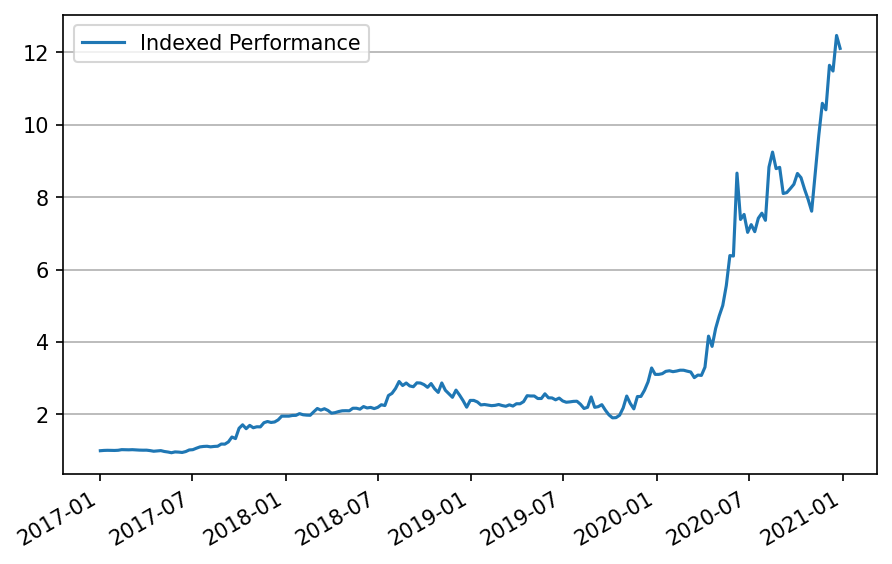

time: 172 ms (started: 2022-10-12 15:21:16 +08:00)


In [69]:
# We see that the biggest gains happened in 2020.
backTest.plot()
plt.grid(axis='y')

# Now loop through model tests and get some statistics to work with.

### Create the different model pipelines

In [41]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
                          ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# ElasticNet/Ridge model pipeline
def trainElasticNetModel(X_train, y_train):
    pl_ElasticNet = Pipeline([('Power Transformer', PowerTransformer()),
                              ('ElasticNet', ElasticNet(l1_ratio=0.00001))])
    pl_ElasticNet.fit(X_train, y_train)
    return pl_ElasticNet

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
                              ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))])
    pl_rfregressor.fit(X_train, y_train)   
    return pl_rfregressor

# GradientBoostingRegressor
def traingbregressorModel(X_train, y_train):
    pl_GradBregressor = Pipeline([
        ('GradBoostRegressor',\
         GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,\
                                   max_depth=10, random_state=42, loss='squared_error'))])
    pl_GradBregressor.fit(X_train, y_train)
    return pl_GradBregressor

# # SVM
# def trainsvmModel(X_train, y_train):
#     pl_svm = Pipeline([('Power Transformer', PowerTransformer()),
#                        ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))])
#     pl_svm.fit(X_train, y_train)
#     return pl_svm

time: 0 ns (started: 2022-10-12 12:51:13 +08:00)


## Testing with all the algorithms to see which training size makes sense (0.5 seems ok)

In [50]:
# Build a list of all the model pipelines
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_GradBregressor', 'pl_rfregressor', 'pl_ElasticNet']

# Here we want to test the performance and volatility of each model and test size.
for model in model_pipeline_list:
    for myTestSize in [0.1, 0.2, 0.3, 0.4, 0.5]:
        
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=myTestSize)
        
        # define the model_pl to be used in the backtest
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train1, y_train1)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train1, y_train1)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train1, y_train1)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train1, y_train1)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train1, y_train1)
        else:
            # Linear model default
            model_pl = trainLinearModel(X_train1, y_train1) 
        
        # Do the backtest
        backTest = getPortTimeSeries(y_test_withdata, X_test1, df_prices, model_pl, verbose=False)
        
        # Find the cumulative performance of the backtest
        perf = backTest['Indexed Performance'][-1]
        
        # Find the volatility of the backtest
        vol = backTest['Indexed Performance'].diff().std()*np.sqrt(52)
        
        print('Performance:', round(perf, 3), 'Annual Volatility:', round(vol, 3), 
              'Test size: ', myTestSize, 'Model:', model)
    print('\n') 

Performance: 1.576 Annual Volatility: 0.315 Test size:  0.1 Model: pl_linear
Performance: 1.603 Annual Volatility: 0.304 Test size:  0.2 Model: pl_linear
Performance: 2.087 Annual Volatility: 0.341 Test size:  0.3 Model: pl_linear
Performance: 1.491 Annual Volatility: 0.299 Test size:  0.4 Model: pl_linear
Performance: 1.704 Annual Volatility: 0.33 Test size:  0.5 Model: pl_linear


Performance: 1.589 Annual Volatility: 0.313 Test size:  0.1 Model: pl_KNeighbors
Performance: 1.641 Annual Volatility: 0.295 Test size:  0.2 Model: pl_KNeighbors
Performance: 1.64 Annual Volatility: 0.324 Test size:  0.3 Model: pl_KNeighbors
Performance: 1.817 Annual Volatility: 0.363 Test size:  0.4 Model: pl_KNeighbors
Performance: 1.872 Annual Volatility: 0.333 Test size:  0.5 Model: pl_KNeighbors


Performance: 1.552 Annual Volatility: 0.31 Test size:  0.1 Model: pl_decTree
Performance: 1.416 Annual Volatility: 0.295 Test size:  0.2 Model: pl_decTree
Performance: 1.379 Annual Volatility: 0.269 Test size

### Running all the models to get out some portfolios, each algorithm 10 runs

In [88]:
def getResultsForModel(model_pipeline_list, runs_per_model=10, verbose=True):
    
    i, results = 0, []
    for model in model_pipeline_list:
        for test_num in range(0, runs_per_model):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
            
            #Train different models
            if (model =='pl_linear'):
                model_pl = trainLinearModel(X_train, y_train)
            if (model =='pl_ElasticNet'):
                model_pl = trainElasticNetModel(X_train, y_train)
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_rfregressor'):
                model_pl = trainrfregressorModel(X_train, y_train)
            if (model =='pl_decTree'):
                model_pl = traindecTreeModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)

            y_test_withdata = y_withdata.loc[X_test.index]
            
            # Here is our backtesting code
            test = getPortTimeSeries(y_test_withdata, X_test, df_prices, model_pl, verbose=False) 
        
            perf = test['Indexed Performance'][-1]
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            if verbose:
                print('Performed test ', i , [i, model, perf, vol])
            results.append([i, model, perf, vol])
            i += 1

    # Save our results for plotting
    results_df = pd.DataFrame(results, columns=["Test Number",\
                                                "Model Used",\
                                                "Indexed Return",\
                                                "Annual Volatility"])

    # Append to an existing results file if available, else make new results file.
    import os
    if os.path.isfile("Backtest_statistics.csv"):
        results_df.to_csv("Backtest_statistics.csv", mode='a', header=False)
    else:
        results_df.to_csv("Backtest_statistics.csv")

time: 0 ns (started: 2022-10-12 15:47:01 +08:00)


In [70]:
y_test_withdata

,Ticker,Date1,Open1,Volume1,Date2,Open2,Volume2
26780,TXT,2017-06-30,46.91,1164977.0,2018-06-30,65.36,915108.0
16361,MC,2019-09-30,32.70,392597.0,2020-09-29,34.17,297734.0
27115,UNH,2018-06-30,245.00,1793431.0,2019-06-30,245.95,4109079.0
18629,NLST,2017-06-30,1.03,39573.0,2018-06-30,0.18,1624342.0
258,ABT,2020-03-31,81.43,23724192.0,2021-03-31,120.00,5792830.0
...,...,...,...,...,...,...,...
22,AA,2018-06-30,46.46,2150764.0,2019-06-30,23.67,3421871.0
25249,T,2017-09-30,29.61,20556490.0,2018-09-30,25.42,29813620.0
5903,CMI,2020-09-30,213.86,1349323.0,2021-09-30,231.30,1094286.0
19675,OMP,2019-09-30,16.18,111739.0,2020-09-29,7.83,126957.0


time: 16 ms (started: 2022-10-12 15:26:12 +08:00)


In [90]:
# # Run with 1 core
# model_pipeline_list = ['pl_rfregressor', 
#                        'pl_decTree', 
#                        'pl_linear', 
#                        'pl_GradBregressor', 
#                        'pl_KNeighbors', 
#                        'pl_ElasticNet']

# getResultsForModel(model_pipeline_list, 2)

time: 0 ns (started: 2022-10-12 15:48:23 +08:00)


In [94]:
# Run in Parallel, with specific models on each core
# Can run this many times, will just keep appending to results file.
model_pipeline_list_list = [['pl_GradBregressor'],
                            ['pl_ElasticNet'],
                            ['pl_decTree'], 
                            ['pl_rfregressor'],
                            ['pl_linear'], 
                            ['pl_KNeighbors']]

import threading
l = len(model_pipeline_list_list)

thread_list = []
for i in range(l):
    thread = threading.Thread(target=getResultsForModel, 
                              args=(model_pipeline_list_list[i], 50, False))
    thread_list.append(thread)
    thread.start()
    print('Thread '+ str(i) + ' started.')

Thread 0 started.
Thread 1 started.
Thread 2 started.
Thread 3 started.
Thread 4 started.
Thread 5 started.
time: 187 ms (started: 2022-10-12 15:49:25 +08:00)


In [114]:
# Can check if threads are still running any time.
# Notebook will look as though nothing is running, but things are running in background.
for i in thread_list:
    print(i.is_alive())

True
True
True
True
True
True
time: 16 ms (started: 2022-10-12 18:08:22 +08:00)


In [96]:
thread_list

[<Thread(Thread-15, started 24664)>,
 <Thread(Thread-16, started 1412)>,
 <Thread(Thread-17, started 32604)>,
 <Thread(Thread-18, started 21960)>,
 <Thread(Thread-19, started 3508)>,
 <Thread(Thread-20, started 17216)>]

time: 63 ms (started: 2022-10-12 15:50:04 +08:00)


# Investigating Backtest Statistics

In [99]:
results_df = pd.read_csv('Backtest_statistics_test.csv', index_col=0)
results_df.reset_index(inplace=True, drop=True)

time: 47 ms (started: 2022-10-12 15:52:35 +08:00)


In [100]:
results_df

,Test Number,Model Used,Indexed Return,Annual Volatility
0,0,pl_GradBregressor,1.387645,0.334411
1,1,pl_GradBregressor,2.954307,0.666284
2,0,pl_rfregressor,2.706360,0.600733
3,1,pl_rfregressor,4.064976,0.722839
4,2,pl_decTree,1.303696,0.171849
...,...,...,...,...
319,95,pl_ElasticNet,1.209510,0.269493
320,96,pl_ElasticNet,1.345216,0.262369
321,97,pl_ElasticNet,1.356474,0.302057
322,98,pl_ElasticNet,1.115710,0.202350


time: 63 ms (started: 2022-10-12 15:52:36 +08:00)


In [117]:
# plotBacktestDist(results_df, pl_model, 'Indexed Return')

def plotBacktestDist(results_df, pl_model, col):
    # Plot the distribution
    ax=results_df[results_df['Model Used']==pl_model][col].hist(bins=50, density=True, alpha=0.7)
    
    # Plot the kde on the same graph
    ax2=results_df[results_df['Model Used']==pl_model][col].plot.kde(alpha=0.9)
    
    # Find the max value of the column to set the x label
    # DELETE IF NOT NEEDED: max_val = results_df[results_df['Model Used']==pl_model][col].max()
    ax.set_xlabel(col)
    
    ax.set_ylabel('Normalised Frequency')
    nruns = results_df[results_df['Model Used']==pl_model][col].size
    ax.set_title(f'{col} Backtest Distribution for {pl_model}, {nruns} Runs')
    ax.grid()
    
    # Find the mean of the many runs
    mean = results_df[results_df['Model Used']==pl_model][col].mean()
    
    # Get the y limits
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns as a red line, simulated returns as green line
        # Figures gathered from NB5 under last row of "Relative" (start 2017 to end 2020)
        ax.plot([1.653526, 1.653526], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=1.5, alpha=1)
        plt.xlim(0, 10)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility as red line, simulated returns as green line
        # Figures gathered from NB5 under last row of "Relative" (start 2017 to end 2020)
        ax.plot([0.23172422345963195, 0.23172422345963195], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=2)  
        plt.xlim(0, 1.5)
    
    # Put a legend in the figures
    ax.legend(['Fitted Smooth Kernel','S&P500 Benchmark', \
               'Simulation Mean {}'.format(round(mean,2)),\
               'Simulation Backtests'])

time: 0 ns (started: 2022-10-12 18:10:47 +08:00)


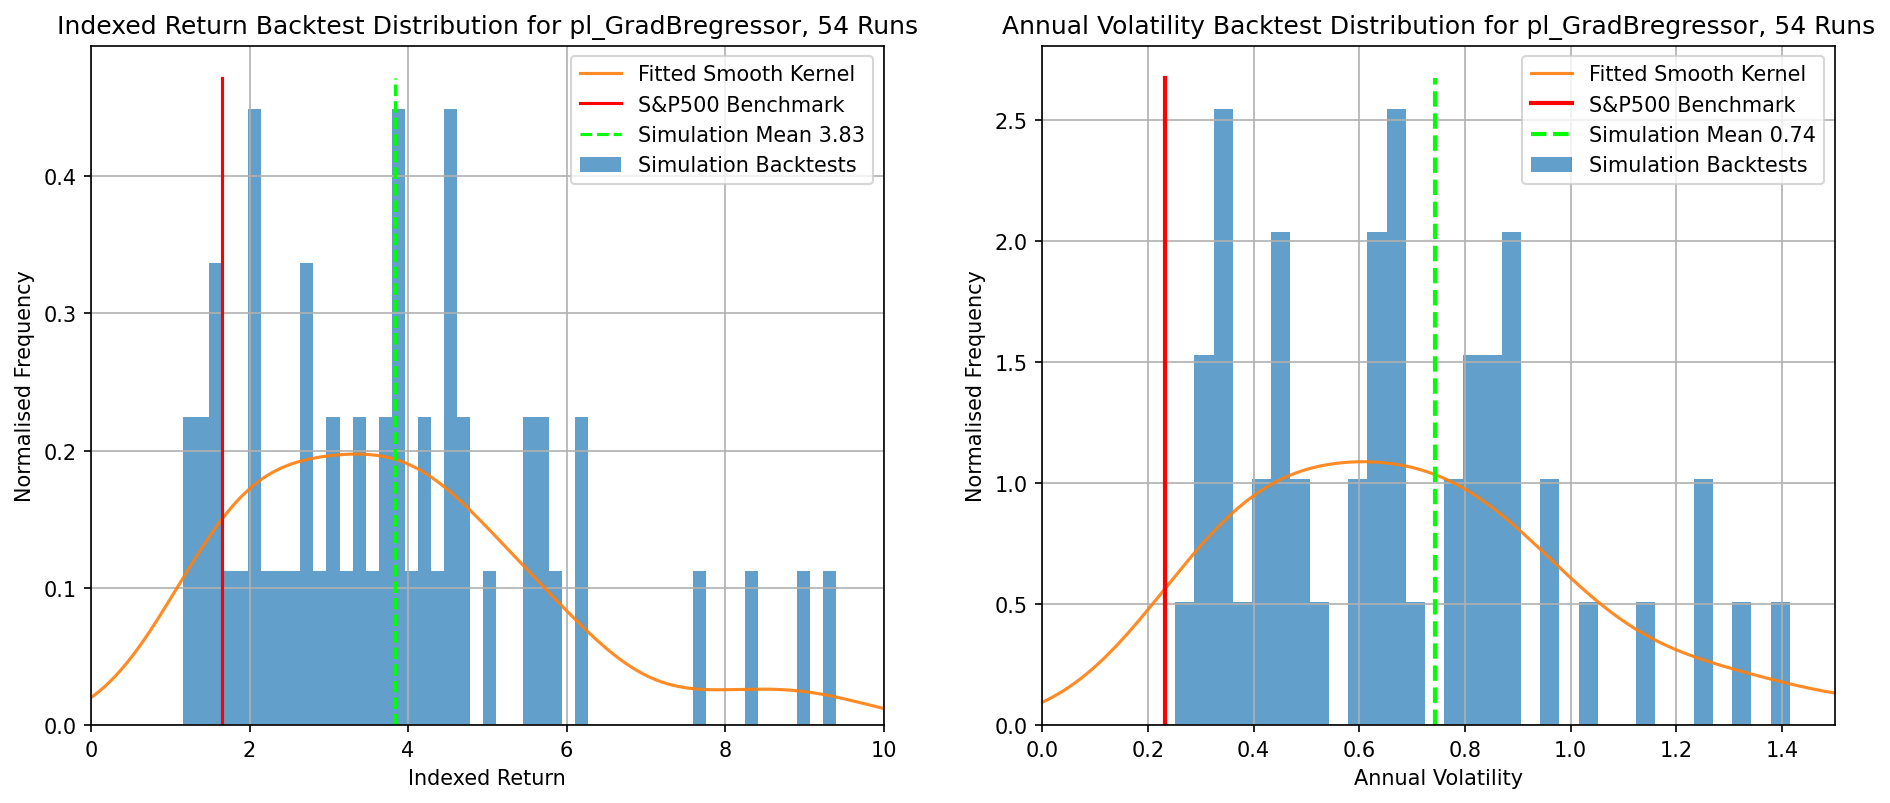

time: 40.7 s (started: 2022-10-12 18:10:48 +08:00)


In [118]:
model_file = 'pl_GradBregressor' #['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors']
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')

plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

In [ ]:
model_file = ['pl_ElasticNet', 'pl_decTree', 'pl_rfregressor', 
              'pl_KNeighbors', 'pl_GradBregressor', 'pl_linear']
#model_file = [, 'pl_ElasticNet']
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm']
#model_file = ['pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_rfregressor']

numPlots = len(model_file)

plt.figure(figsize=(15,6*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Chosen Regressors for AI are GradBoost and KNN

We will expect more volatility.

In [ ]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['Gradient Boosted Decision Tree Regressor', 'S&P500'])
plt.title('Gradient Boost Backtest Return vs. Volatility', fontsize=14)

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['K Nearest Neighbours Regressor', 'S&P500'])
plt.title('KNN Backtest Return vs. Volatility', fontsize=14)

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([3.511822, 3.511822], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Return', fontsize=14)
plt.xlabel('Indexed Return')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([0.325059094152396, 0.325059094152396], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Volatility', fontsize=14)
plt.xlabel('Annual Volatility')

# Figure out what the actual performance should be

In [ ]:
# Choose the model pipelines to run loop for
model_pipeline_list = ['pl_GradBregressor', 'pl_KNeighbors']
tests_per_model=20

# Reduce test size and check performance to try and see a trend
# Is effectively *0.5 as test size is 1/2 of total data.
#test_size_modifier_list = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05 ]
test_size_modifier_list = [0.05, 0.075]

# Results DataFrame
results_df2 = pd.DataFrame( columns=["Test Number",
                                            "Model Used",\
                                            "Test Set Size",\
                                            "Indexed Return",\
                                            "Annual Volatility"])

i, results = 0, []
for model in model_pipeline_list:
    for test_size_mod in test_size_modifier_list:
        for test_num in range(0, tests_per_model):
            
            X_train, X_test, y_train, y_test = \
            train_test_split(X, y_pec, test_size=0.5)
            
            new_test_size = round(len(X_test)//(1/test_size_mod))
            
            X_test, y_test = \
            X_test[:new_test_size], y_test[:new_test_size]
            
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withData_Test, X_test,
                     daily_stock_prices, model_pl, 
                         verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            #print('Performed test ',i , [i, model, new_test_size, perf, vol])     
            
            results_df2=results_df2.append(\
                        pd.DataFrame(\
                             [[i, model, new_test_size, perf, vol]],\
                                     columns=results_df2.keys()))      
            i=i+1
            
        print('For {} test size {}, Performance: {}, Vol: {}.'.format(\
              model, new_test_size, \
            results_df2['Indexed Return'].tail(tests_per_model).mean(),\
            results_df2['Annual Volatility'].tail(tests_per_model).mean()))

# Save our results for plotting
results_df2.to_csv("Backtest_statistics_Modified_test_size.csv")

In [ ]:
test_set_size = [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05]
gradB_avgReturn = [4.23, 4.44, 3.39, 3.6, 3.29, 3.42, 3.42]
knn_avgReturn = [4.68, 4.32, 4.49, 3.83, 3.30, 3.31, 2.85]


plt.figure(figsize=(12,4))

linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(gradB_avgReturn).reshape(-1,1))
plt.subplot(1,2,1)
plt.scatter(test_set_size, gradB_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('GradBoost Decision Tree\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(knn_avgReturn).reshape(-1,1))
plt.subplot(1,2,2)
plt.scatter(test_set_size, knn_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('K-Nearest Neighbours\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


# Final Stock Selection for 2020 with Gradient Boosted Decision Tree and K Nearest Neighbours

In [ ]:
def pickStockForMe(model='GBoost'):
    '''
    Pick stocks.
    Reads Annual_Stock_Price_Fundamentals_Ratios.csv,
    and Annual_Stock_Price_Performance_Percentage.csv,
    trains the AI with the best model/parameters,
    Then picks stocks using outputs from Notebooks 1 and 2:
    Annual_Stock_Price_Fundamentals_Ratios_2021.csv,
    and Tickers_Dates_2021.csv.
    Outputs a DataFrame of best picks.
    '''
    # Training X and Y of all previous year data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
                  index_col=0)
    # annual stock performances
    yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", 
                      index_col=0)
    
    yperf=yperf["Perf"]

    # Stock selection ratios for 2021 X
    X_2021=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_2021.csv"
                       , index_col=0)
    # And the row tickers
    tickers=pd.read_csv("Tickers_Dates_2021.csv", index_col=0)
    
    if model == 'GBoost':
        # Gradient Boosted tree
        model_pl = traingbregressorModel(X, yperf)
        y_pred=model_pl.predict(X_2021)
        y_pred=pd.DataFrame(y_pred)
    
    elif model == 'KNN':
        # KNN
        model_pl = trainKNeighborsModel(X, yperf)
        y_pred=model_pl.predict(X_2021)
        y_pred=pd.DataFrame(y_pred)
    
    else:
        return None

    # FINAL STOCK PICKS
    # Separate out stocks with low Z scores
    # 3.75 is approx. B- rating
    z = calcZScores(X_2021)
    zbl = (z['Z score'].reset_index(drop=True) > 2) 

    Final_Predictions = pd.DataFrame()
    Final_Predictions[['Ticker','Report Date']] = \
    tickers[['Ticker','Date']].reset_index(drop=True)\
                               [zbl].reset_index(drop=True)
    
    Final_Predictions['Perf. Score'] = y_pred.reset_index(drop=True)\
                                       [zbl].reset_index(drop=True)

    return Final_Predictions.sort_values(by='Perf. Score', 
                                         ascending=False)\
                                    .reset_index(drop=True).head(20)

In [ ]:
# What it's all about.
pickStockForMe()

In [ ]:
pickStockForMe('KNN')